<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# LIBRERÍAS

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import scipy.stats as stats
from scipy.stats import norm, sem

import pylab as plt
import seaborn as sns
%matplotlib inline

In [2]:
# DATOS

data = pd.read_csv('data/cookie_cats.csv')

data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
# TRANSFORMACIÓN

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
# Comprobamos si existen usuarios presentes en las dos versiones (esto supondría un problema a la hora de establecer el grupo de control).

users = data.userid.value_counts(ascending=False)

multi_users = users[users>1].count()

multi_users

# Observamos que no existen usuarios duplicados (todos están en una versión u otra, pero no en las dos)

0

In [5]:
# MUESTREO

In [6]:
# Tomaremos muestras del mayor tamaño posible según los datos disponibles.

data.version.value_counts()

# Como la cantidad de registros para cada versión no es igual, tomaremos una muestra aleatoria de gate_40 para que tenga el mismo tamaño que gate_30 (44.700).

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [7]:
tratamiento = data[data.version == 'gate_40'].sample(n = 44700, random_state = 42)

tratamiento.head()

,userid,version,sum_gamerounds,retention_1,retention_7
40554,4486568,gate_40,1,False,False
83613,9265806,gate_40,10,False,False
71485,7922317,gate_40,12,False,False
21925,2440769,gate_40,46,True,False
12383,1370609,gate_40,10,False,False


In [8]:
control = data[data.version=='gate_30']

control.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
6,1066,gate_30,0,False,False
11,2101,gate_30,0,False,False
13,2179,gate_30,39,True,False


In [9]:
ab_test = pd.concat([control, tratamiento], axis=0)

ab_test.version.value_counts()

# Ya tenemos dos muestras del mismo tamaño.

gate_30    44700
gate_40    44700
Name: version, dtype: int64

In [10]:
ab_test.reset_index(drop=True, inplace=True)

ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,1066,gate_30,0,False,False
3,2101,gate_30,0,False,False
4,2179,gate_30,39,True,False


In [11]:
# TESTEO para retention_1

retention = ab_test.groupby('version')['retention_1']

std=lambda x: np.std(x, ddof=0)             # std poblacional
error_std=lambda x: stats.sem(x, ddof=0)    # error estandard (std/sqrt(n))


In [12]:
retention = retention.agg([np.mean, std, error_std])   # Generamos DataFrame con los valores que nos interesan.

In [13]:
retention.columns=['conv_rate', 'std', 'error_std']   # Cambiamos los nombres de columnas.

retention

,conv_rate,std,error_std
version,,,
gate_30,0.448188,0.497308,0.002352
gate_40,0.442573,0.496691,0.002349


In [14]:
retention.style.format('{:.3f}')   # Mostramos los valores con tres decimales.

,conv_rate,std,error_std
version,,,
gate_30,0.448,0.497,0.002
gate_40,0.443,0.497,0.002


'Observamos que la diferencia en la retención es muy escasa y, además, la retención en el grupo de control es algo superior que en el de tratamiento.\n\nEn principio podríamos descartar una mejora en la retención con las modificaciones propuestas (grupo de tratamiento).\n\nMás allá de que esta diferencia sea estadísticamente significativa o no, la introdicción de los cambios parece perjudicial para el negocio.\n\nNo obstante, testearemos significación esta diferencia para asegurarnos de la fiabilidad de los datos y completar el proceso como es debido.'

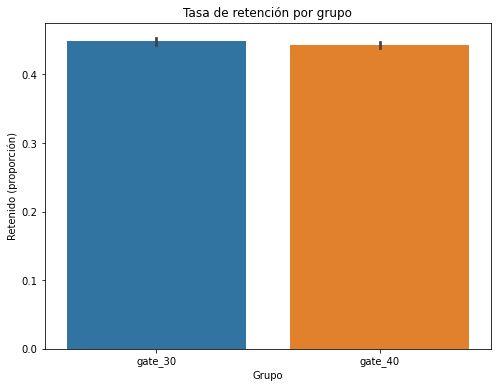

In [15]:
# Visualizamos los datos de la población.

plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_1'])

plt.title('Tasa de retención por grupo')
plt.xlabel('Grupo')
plt.ylabel('Retenido (proporción)');


'''Observamos que la diferencia en la retención es muy escasa y, además, la retención en el grupo de control es algo superior que en el de tratamiento.

En principio podríamos descartar una mejora en la retención con las modificaciones propuestas (grupo de tratamiento).

Más allá de que esta diferencia sea estadísticamente significativa o no, la introducción de los cambios parece perjudicial para el negocio.

No obstante, testearemos la significación de esta diferencia para asegurarnos de la fiabilidad de los datos y completar el proceso como es debido.'''

In [66]:
# Testeo de HIPÓTESIS para retention_1

control_retention = ab_test[ab_test.version=='gate_30']['retention_1']        # Extraemos los valores de retención para cada grupo.
tratamiento_retention = ab_test[ab_test.version=='gate_40']['retention_1']


In [67]:
n_con = control_retention.count()        # cantidad de observaciones por grupo.
n_trat = tratamiento_retention.count()

retentions = [control_retention.sum(), tratamiento_retention.sum()]  # cantidad de retenciones por grupo (retention_1 = True).

observaciones = [n_con, n_trat] # cuenta N de cada grupo (44.700 por grupo, tal y como definimos en el muestreo)

z_score, p_value = proportions_ztest(retentions, nobs=observaciones)

z_score, p_value

(1.6890473061671334, 0.09121036470055781)

In [68]:
# Estudiamos los intervalos de confianza:

(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(retentions, 
                                                                           nobs=observaciones,
                                                                           alpha=0.05)

# se definen las dos tuplas de salida del confint

print('Control', [control_a, control_b])
print('Tratamiento', [tratamiento_a, tratamiento_b])

# Observamos también mediante los intervalos como los cambios no mejorarán la tasa de retención.

Control [0.44357771693415227, 0.4527981219920222]
Tratamiento [0.43796822516446715, 0.4471771887057789]


In [33]:
''' Obtenemos un p-valor demasiado elevado. En principio trabajamos con un nivel de confianza del 95% y, como el p-valor es superior a 0,05; no podemos rechazar la hipótesis nula.

No rechazamos hipótesis nula, por lo que no podemos afirmar que la diferencia existente sea estadísticamente significativa.

CONCLUSIÓN retention_1:
    - El grupo de tratamiento ofrece un ratio de retención inferior al grupo de control.
    - Esta diferencia no es estadísticamente significativa, por lo que ni siquiera podemos confirmat una diferencia real en la tasa de retención del grupo de tratamiento.
    - Los resultados de retención en un periodo de tiempo de un día bajo el nuevo sistema gate_40 no son satisfactorios. Desde esta perspectiva se recomieda no implementar los cambios. '''

' Obtenemos un p-valor demasiado elevado. En principio trabajamos con un nivel de confianza del 95% y, como el p-valor es superior a 0,05; no podemos rechazar la hipótesis nula.\n\nNo rechazamos hipótesis nula, por lo que no podemos afirmar que la diferencia existente sea estadísticamente significativa.\n\nCONCLUSIÓN retention_1:\n    - El grupo de tratamiento ofrece un ratio de retención inferior al grupo de control.\n    - Esta diferencia no es estadísticamente significativa.\n    - Los resultados de retención en un periodo de tiempo de un día bajo el nuevo sistema gate_40 no son satisfactorios. Desde esta perspectiva se recomieda no implementar los cambios. '

In [16]:
# TESTEO para retention_7

# Aunque los resultados para retention_1 no son satisfactorios, testearemos también la retención a 7 días para estudiar más a fondo los resultados del grupo de tratamiento.

In [38]:
retention_7 = ab_test.groupby('version')['retention_7']

std=lambda x: np.std(x, ddof=0)             # std poblacional
error_std=lambda x: stats.sem(x, ddof=0)    # error estandard (std/sqrt(n))


In [39]:
retention_7 = retention_7.agg([np.mean, std, error_std])   # Generamos DataFrame con los valores que nos interesan.

In [40]:
retention_7.columns=['conv_rate', 'std', 'error_std']   # Cambiamos los nombres de columnas.

retention_7

,conv_rate,std,error_std
version,,,
gate_30,0.190201,0.392460,0.001856
gate_40,0.182438,0.386205,0.001827


In [41]:
retention_7.style.format('{:.3f}')   # Mostramos los valores con tres decimales.

,conv_rate,std,error_std
version,,,
gate_30,0.190,0.392,0.002
gate_40,0.182,0.386,0.002


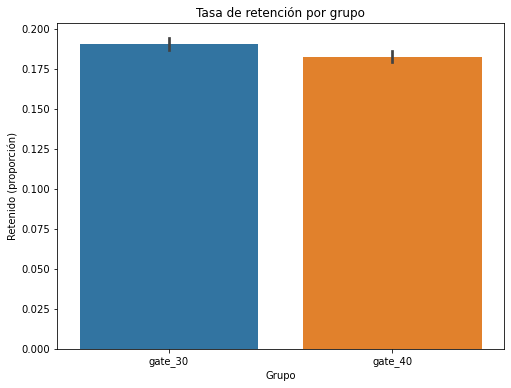

In [42]:
# Visualizamos los datos de la población.

plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['version'], 
            y=ab_test['retention_7'])

plt.title('Tasa de retención por grupo')
plt.xlabel('Grupo')
plt.ylabel('Retenido (proporción)');

''' Ocurre algo similar que con retention_1, pero en este caso la diferencia (a la baja) en la tasa de retención es aún mayor.

De nuevo, a priori podríamos descartar una mejora en la retención con las modificaciones propuestas (grupo de tratamiento).

Más allá de que esta diferencia sea estadísticamente significativa o no, la introducción de los cambios parece perjudicial para el negocio.

No obstante, testearemos la significación de esta diferencia para asegurarnos de la fiabilidad de los datos y completar el proceso como es debido.'''

In [69]:
# Testeo de HIPÓTESIS para retention_7

control_retention_7 = ab_test[ab_test.version=='gate_30']['retention_7']        # Extraemos los valores de retención para cada grupo.
tratamiento_retention_7 = ab_test[ab_test.version=='gate_40']['retention_7']

In [70]:
n_con_7 = control_retention_7.count()        # cantidad de observaciones por grupo.
n_trat_7 = tratamiento_retention_7.count()

retentions_7 = [control_retention_7.sum(), tratamiento_retention_7.sum()]  # cantidad de retenciones por grupo (retention_1 = True).

observaciones_7 = [n_con, n_trat] # cuenta N de cada grupo (44.700 por grupo, tal y como definimos en el muestreo)

z_score, p_value = proportions_ztest(retentions_7, nobs=observaciones_7)

z_score, p_value

(2.9806037079284167, 0.002876808101694685)

In [ ]:
''' En principio trabajamos con un nivel de confianza del 95%. Al obtener un p-valor inferior a 0.05 podemos rechazar la hipótesis nula.

Rechazamos que no existe una diferencia significativa en la tasa de retención del grupo de tratamiento frente al grupo de control.

Sin embargo, esta diferencia no es la deseada. El grupo de tratamiento ofrece una tasa de retención a los 7 días inferior al grupo de control.

Es decir, es cierto que los cambios implican una diferencia significativa en los resultados de retención (a 7 días), pero esta diferencia es a peor.

Por tanto, desde esta perspectiva tampoco recomendaríamos implantar los cambios testeados (gate_40).'''

In [71]:
# Estudiamos los intervalos de confianza:

(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(retentions_7, 
                                                                           nobs=observaciones_7,
                                                                           alpha=0.05)

# se definen las dos tuplas de salida del confint

print('Control', [control_a, control_b])
print('Tratamiento', [tratamiento_a, tratamiento_b])

# Observamos también mediante los intervalos como los cambios no mejorarán la tasa de retención.

Control [0.18656311652199903, 0.19383956804175934]
Tratamiento [0.17885823353926938, 0.1860187239551378]


In [17]:
# CONCLUSIONES FINALES:

'''En base a los resultados de los tests desarrollados, podemos afirmar que los cambios propuestos no deben ser implementados.

Los cambios en los resultados de retención en el grupo de tratamiento son a la baja, es decir, la tasa de retención disminuye.

En el caso de la retención a un día, esta diferencia no es estadísticamente significativa, por lo que no podemos afirmar que los cambios producidos impacten en la tasa de retención (bajo un nivel de confianza del 95% o superior).
Encontramos una diferencia desfavorable en la tasa de retención, pero no podemos afirmar que esta diferencia sea significativa.
En cualquier caso, no encontramos una diferencia favorable (signicativa o no), por lo que no podemos recomendar la implantación de los cambios (desde el punto de vista de la tasa de conversión a un día).

En cuanto a la retención a siete días, sí que encontramos una diferencia estadísticamente significativa en los resultados de conversión. 
Sin embargo, esta diferencia supone un escenario menos favorable para el negocio (tasa de retención más baja).
A partir de estos resultados, podemos afirmar que existe una diferencia significativa desfavorable y debemos recomentar que no se implementen los cambios (desde el punto de vusta de la tasa de conversión a siete días).

En conclusión, no recomendamos implementar los cambios propuestos.
Si esto se hiciera, podemos esperar una bajada en la retención a siete días (existe diferencia desfavorable y es significativa) y no podemos afirmar que vayan a producirse cambios en la retención a un día (existe diferencia desfavorable, aunque no es significativa).
Es decir, según es test podemos esperar cambios negativos en la retención a 7 días y no podemos esperar cambios significativos en la retención a un día.
'''